# Statistical Analysis of Excel Data
This notebook performs data import, summary statistics, normality tests, ANOVA/Friedman tests, post-hoc analysis, and effect size calculations for two channels across different conditions.

In [14]:
import pandas as pd
from IPython.display import display
from scipy.stats import f_oneway, shapiro, ttest_rel, wilcoxon
import pingouin as pg
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from statsmodels.sandbox.stats.multicomp import multipletests
import scipy.stats as stats  # Import scipy.stats


In [15]:
# Path to your Excel file
excel_path = 'statistike.xlsx'
df_all = pd.read_excel(excel_path, sheet_name="Statistike vseh obravnav pacien")
display(df_all.head())

,način,ID,ITM razred,Tel dejav razred,Kanal 1 Povprečje delovanja,Kanal 1 Odklon od povprečja delovanja,Column1,Kanal 1 Vrh,Kanal 2 Povprečje delovanja,Kanal 2 Odklon od povprečja delovanja,Column2,Kanal 2 Vrh,Kanal 1 Povprečje mirovanja,Kanal 1 Odklon od povprečja mirovanja,Column3,Kanal 1 Minimum,Kanal 2 Povprečje mirovanja,Kanal 2 Odklon od povprečja mirovanja,Column4,Kanal 2 Minimum
0,nosnos,1354,1,2,3.536849,0.621890,0.175832,10.9,4.366164,0.874796,0.200358,10.90,3.695455,0.805859,0.218068,1.27,4.669596,0.945205,0.202417,1.53
1,ustpripora,1354,1,2,2.243514,0.582542,0.259656,5.4,1.592973,0.544719,0.341951,5.41,1.986578,0.458973,0.231037,0.74,1.460199,0.441143,0.302112,0.56
2,ššš,1354,1,2,2.157181,0.503344,0.233334,6.3,1.670940,0.484776,0.290122,7.40,1.954916,0.404280,0.206802,0.84,1.862155,0.565431,0.303643,0.57
3,sss,1354,1,2,2.524362,0.496311,0.196608,5.3,2.017450,0.572784,0.283915,5.80,2.384983,0.476827,0.199929,1.11,1.905797,0.516088,0.270799,0.87
4,popek,1354,1,2,13.964437,2.621669,0.187739,55.0,19.255364,4.528746,0.235194,96.00,19.278389,6.835292,0.354557,5.80,28.180705,11.823276,0.419552,5.40


In [16]:
pivot_df = df_all.pivot_table(
    index=['ID'],
    columns='način',
    values=[
        'Kanal 1 Povprečje mirovanja',
        'Kanal 2 Povprečje mirovanja'
    ],
    aggfunc='first'
)
display(pivot_df.head())

Kanal 1 Povprečje mirovanja                                              \
način                      nosnos         pas      popek       sss ustpripora   
ID                                                                              
804                      4.246321   32.898503  13.650100  3.323571   3.039732   
1212                     2.203456   15.260973  14.170233  1.126309   2.975338   
1252                    28.473826  155.576701  31.110102  3.698495   9.735604   
1354                     3.695455   24.924628  19.278389  2.384983   1.986578   
2038                     2.030602    6.030370   7.703027  1.942074   2.552642   

                 Kanal 2 Povprečje mirovanja                                   \
način        ššš                      nosnos         pas      popek       sss   
ID                                                                              
804     6.860767                    4.378194   23.058605  11.321472  3.771701   
1212    1.938400                    1.930302   11.182181  11.091267  1.204664   
1252   16.468986                   41.423087  163.767347  31.188847  3.764849   
1354    1.954916                    4.669596   40.915473  28.180705  1.905797   
2038    2.675100                    2.360368    6.274074   5.359660  2.295184   

                             
način ustpripora        ššš  
ID                           
804     3.161477   6.783300  
1212    2.152331   1.354967  
1252   15.146342  17.058851  
1354    1.460199   1.862155  
2038    2.923846   2.378633

In [17]:
def calculate_rms(group):
    """Calculate RMS for each column in the group."""
    rms_values = {}
    for column in group.columns:
        if column in group.columns:
            squared_values = group[column] ** 2
            mean_squared = squared_values.mean()
            rms = np.sqrt(mean_squared)
            rms_values[column] = rms
        else:
            rms_values[column] = None
    return pd.Series(rms_values)

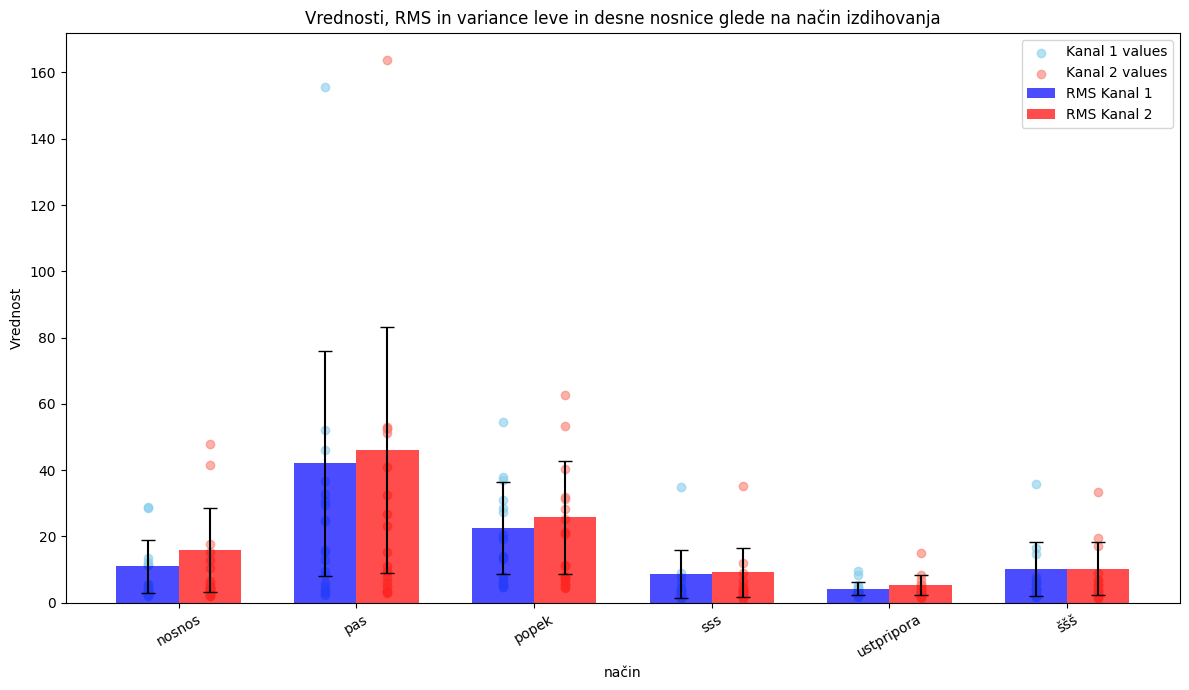

,RMS Kanal 1,Std Kanal 1,RMS Kanal 2,Std Kanal 2
način,,,,
nosnos,11.024081,8.036923,15.947591,12.723349
pas,42.093222,33.998818,46.082082,36.986017
popek,22.554640,13.947154,25.801697,17.056470
sss,8.765331,7.277858,9.167049,7.491096
ustpripora,4.290275,2.018394,5.295614,3.078123
ššš,10.187899,8.019875,10.318400,7.931801


Word document exported as 'RMS_and_variance_analysis.docx'


In [24]:
from docx import Document
from docx.shared import Inches
import io

import matplotlib.pyplot as plt

# Calculate RMS and variances for Kanal 1 & 2 Povprečje mirovanja by 'način'
rms_kanal1 = df_all.groupby('način')['Kanal 1 Povprečje mirovanja'].apply(lambda x: np.sqrt(np.mean(x**2)))
vars_kanal1 = df_all.groupby('način')['Kanal 1 Povprečje mirovanja'].var()
rms_kanal2 = df_all.groupby('način')['Kanal 2 Povprečje mirovanja'].apply(lambda x: np.sqrt(np.mean(x**2)))
vars_kanal2 = df_all.groupby('način')['Kanal 2 Povprečje mirovanja'].var()

labels = rms_kanal1.index
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

# Plot all individual values as scatter for Kanal 1 and Kanal 2
for i, nacin in enumerate(labels):
    y1 = df_all[df_all['način'] == nacin]['Kanal 1 Povprečje mirovanja']
    y2 = df_all[df_all['način'] == nacin]['Kanal 2 Povprečje mirovanja']
    ax.scatter(np.full_like(y1, x[i] - width/2), y1, color='skyblue', alpha=0.6, label='Kanal 1 values' if i == 0 else "")
    ax.scatter(np.full_like(y2, x[i] + width/2), y2, color='salmon', alpha=0.6, label='Kanal 2 values' if i == 0 else "")

# Plot RMS with error bars (variance as error) for Kanal 1 and Kanal 2
rects1 = ax.bar(x - width/2, rms_kanal1, width, yerr=vars_kanal1**0.5, label='RMS Kanal 1', color='blue', alpha=0.7, capsize=5)
rects2 = ax.bar(x + width/2, rms_kanal2, width, yerr=vars_kanal2**0.5, label='RMS Kanal 2', color='red', alpha=0.7, capsize=5)

ax.set_ylabel('Vrednost')
ax.set_xlabel('način')
ax.set_title('Vrednosti, RMS in variance leve in desne nosnice glede na način izdihovanja')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.legend()
plt.tight_layout()
plt.show()

# Create a summary table of RMS and standard deviations for Kanal 1 & 2 Povprečje mirovanja by 'način'
summary_stats = pd.DataFrame({
    'RMS Kanal 1': rms_kanal1,
    'Std Kanal 1': vars_kanal1**0.5,
    'RMS Kanal 2': rms_kanal2,
    'Std Kanal 2': vars_kanal2**0.5
})
display(summary_stats)

# Create a Word document
doc = Document()
doc.add_heading('RMS and Variance Analysis', 0)

# Add summary table
doc.add_heading('Summary Table', level=1)
table = doc.add_table(rows=1, cols=len(summary_stats.columns) + 1)
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'način'
for i, col in enumerate(summary_stats.columns):
    hdr_cells[i + 1].text = col
for idx, row in summary_stats.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = str(idx)
    for i, val in enumerate(row):
        row_cells[i + 1].text = f"{val:.3f}"

# Save the plot to a BytesIO buffer
img_stream = io.BytesIO()
fig.savefig(img_stream, format='png')
img_stream.seek(0)

# Add the plot to the document
doc.add_heading('RMS and Variance Plot', level=1)
doc.add_picture(img_stream, width=Inches(6))

# Save the document
doc.save('RMS_and_variance_analysis.docx')
print("Word document exported as 'RMS_and_variance_analysis.docx'")

In [27]:
import seaborn as sns

# Gather Shapiro-Wilk p-values in a table
normality_results = []

for kanal in ['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']:
    for name, group in df_all.groupby('način'):
        stat, p = shapiro(group[kanal].dropna())
        interpretation = "Normal" if p >= 0.05 else "Not normal"
        normality_results.append({
            'Channel': kanal,
            'način': name,
            'Statistic': stat,
            'p-value': p,
            'Interpretation': interpretation
        })

normality_df = pd.DataFrame(normality_results)
display(normality_df)


,Channel,način,Statistic,p-value,Interpretation
0,Kanal 1 Povprečje mirovanja,nosnos,0.689091,2.878778e-05,Not normal
1,Kanal 1 Povprečje mirovanja,pas,0.631756,6.396509e-06,Not normal
2,Kanal 1 Povprečje mirovanja,popek,0.860637,8.077496e-03,Not normal
3,Kanal 1 Povprečje mirovanja,sss,0.471553,1.775766e-07,Not normal
4,Kanal 1 Povprečje mirovanja,ustpripora,0.769098,3.097132e-04,Not normal
5,Kanal 1 Povprečje mirovanja,ššš,0.609580,3.706577e-06,Not normal
6,Kanal 2 Povprečje mirovanja,nosnos,0.630227,6.156548e-06,Not normal
7,Kanal 2 Povprečje mirovanja,pas,0.667935,1.624980e-05,Not normal
8,Kanal 2 Povprečje mirovanja,popek,0.831234,2.625660e-03,Not normal
9,Kanal 2 Povprečje mirovanja,sss,0.508903,3.830242e-07,Not normal


Primerjava kanala 1 in 2 mirovanja za vsak način, narejen je wilcoxon

In [31]:
from scipy.stats import wilcoxon

# For each način, compare Kanal 1 and Kanal 2 Povprečje mirovanja using Wilcoxon signed-rank test
wilcoxon_results = []
for nacin in df_all['način'].unique():
    subset = df_all[df_all['način'] == nacin]
    kanal1 = subset['Kanal 1 Povprečje mirovanja']
    kanal2 = subset['Kanal 2 Povprečje mirovanja']
    # Only test if both columns have at least 2 non-NaN values
    if len(kanal1.dropna()) > 1 and len(kanal2.dropna()) > 1:
        stat, p = wilcoxon(kanal1, kanal2)
        print(f"{nacin}: Wilcoxon test statistic={stat:.4f}, p-value={p:.4g}")
        interpretation = "Significant difference" if p < 0.05 else "No significant difference"
        wilcoxon_results.append({
            'način': nacin,
            'Wilcoxon statistic': stat,
            'p-value': p,
            'Interpretation': interpretation
        })
    else:
        print(f"{nacin}: Not enough data for test")
        wilcoxon_results.append({
            'način': nacin,
            'Wilcoxon statistic': None,
            'p-value': None,
            'Interpretation': "Not enough data"
        })

wilcoxon_df = pd.DataFrame(wilcoxon_results)
display(wilcoxon_df)

nosnos: Wilcoxon test statistic=35.0000, p-value=0.007296
ustpripora: Wilcoxon test statistic=79.0000, p-value=0.3488
ššš: Wilcoxon test statistic=69.0000, p-value=0.1893
sss: Wilcoxon test statistic=45.0000, p-value=0.02395
popek: Wilcoxon test statistic=76.0000, p-value=0.2943
pas: Wilcoxon test statistic=74.0000, p-value=0.2611


,način,Wilcoxon statistic,p-value,Interpretation
0,nosnos,35.0,0.007296,Significant difference
1,ustpripora,79.0,0.348810,No significant difference
2,ššš,69.0,0.189348,No significant difference
3,sss,45.0,0.023951,Significant difference
4,popek,76.0,0.294252,No significant difference
5,pas,74.0,0.261099,No significant difference


razlika je le pri nosnos in sss. 

In [ ]:
# Friedman test for Kanal 1 (mirovanja)
print('\nFriedmanov test za Kanal 1 (mirovanja):')
friedman_test = pg.friedman(data=df_all, dv='Kanal 1 Povprečje mirovanja', within='način', subject='ID')
display(friedman_test)
# Friedman test for Kanal 2 (mirovanja)
print('\nFriedmanov test za Kanal 2 (mirovanja):')
friedman_test_kanal2 = pg.friedman(data=df_all, dv='Kanal 2 Povprečje mirovanja', within='način', subject='ID')
display(friedman_test_kanal2)


Friedmanov test za Kanal 1 (mirovanja):


,Source,W,ddof1,Q,p-unc
Friedman,način,0.426857,5,42.685714,4.278666e-08



Friedmanov test za Kanal 2 (mirovanja):


,Source,W,ddof1,Q,p-unc
Friedman,način,0.452857,5,45.285714,1.269209e-08


Zaključimo, da so si potenciali pri različnih načinih statistično različni (p<0.05).

In [32]:
# Post-hoc Tukey test for Kanal 1 (mirovanja)
print('\nPost-hoc Tukey test with Bonferroni correction for Kanal 1 (mirovanja):')
posthoc_kanal1 = pg.pairwise_tukey(data=df_all, dv='Kanal 1 Povprečje mirovanja', between='način')
display(posthoc_kanal1)
# Post-hoc Tukey test for Kanal 2 (mirovanja)
print('\nPost-hoc Tukey test with Bonferroni correction for Kanal 2 (mirovanja):')
posthoc_kanal2 = pg.pairwise_tukey(data=df_all, dv='Kanal 2 Povprečje mirovanja', between='način')
display(posthoc_kanal2)

# Export Tukey post-hoc results to Word
tukey_doc = Document()
tukey_doc.add_heading('Post-hoc Tukey test with Bonferroni correction', 0)

# Kanal 1 table
tukey_doc.add_heading('Kanal 1 Povprečje mirovanja', level=1)
table1 = tukey_doc.add_table(rows=1, cols=len(posthoc_kanal1.columns))
for i, col in enumerate(posthoc_kanal1.columns):
    table1.cell(0, i).text = str(col)
for _, row in posthoc_kanal1.iterrows():
    cells = table1.add_row().cells
    for i, val in enumerate(row):
        cells[i].text = f"{val:.4f}" if isinstance(val, (float, np.floating)) else str(val)

# Kanal 2 table
tukey_doc.add_heading('Kanal 2 Povprečje mirovanja', level=1)
table2 = tukey_doc.add_table(rows=1, cols=len(posthoc_kanal2.columns))
for i, col in enumerate(posthoc_kanal2.columns):
    table2.cell(0, i).text = str(col)
for _, row in posthoc_kanal2.iterrows():
    cells = table2.add_row().cells
    for i, val in enumerate(row):
        cells[i].text = f"{val:.4f}" if isinstance(val, (float, np.floating)) else str(val)

tukey_doc.save('Post-hoc Tukey test with Bonferroni correction.docx')
print("Word document exported as 'Post-hoc Tukey test with Bonferroni correction.docx'")


Post-hoc Tukey test with Bonferroni correction for Kanal 1 (mirovanja):


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,nosnos,pas,7.756793,25.956034,-18.199241,5.060294,-3.596479,0.006219,-0.722075
1,nosnos,popek,7.756793,17.997635,-10.240842,5.060294,-2.023764,0.335505,-0.881838
2,nosnos,sss,7.756793,5.148996,2.607797,5.060294,0.515345,0.995485,0.333384
3,nosnos,ustpripora,7.756793,3.812642,3.944150,5.060294,0.779431,0.970485,0.659754
4,nosnos,ššš,7.756793,6.533820,1.222973,5.060294,0.241680,0.999885,0.149304
5,pas,popek,25.956034,17.997635,7.958399,5.060294,1.572715,0.618083,0.300184
6,pas,sss,25.956034,5.148996,20.807038,5.060294,4.111824,0.001029,0.829502
7,pas,ustpripora,25.956034,3.812642,22.143392,5.060294,4.375910,0.000380,0.901190
8,pas,ššš,25.956034,6.533820,19.422214,5.060294,3.838159,0.002742,0.770684
9,popek,sss,17.997635,5.148996,12.848639,5.060294,2.539109,0.121575,1.132082



Post-hoc Tukey test with Bonferroni correction for Kanal 2 (mirovanja):


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,nosnos,pas,10.026776,28.705246,-18.678470,5.69982,-3.277028,0.017059,-0.661937
1,nosnos,popek,10.026776,19.731968,-9.705192,5.69982,-1.702719,0.532874,-0.632190
2,nosnos,sss,10.026776,5.542932,4.483844,5.69982,0.786664,0.969282,0.420942
3,nosnos,ustpripora,10.026776,4.363763,5.663013,5.69982,0.993542,0.919148,0.599645
4,nosnos,ššš,10.026776,6.833855,3.192920,5.69982,0.560179,0.993333,0.295184
5,pas,popek,28.705246,19.731968,8.973278,5.69982,1.574309,0.617045,0.305381
6,pas,sss,28.705246,5.542932,23.162314,5.69982,4.063692,0.001227,0.850774
7,pas,ustpripora,28.705246,4.363763,24.341482,5.69982,4.270570,0.000569,0.909097
8,pas,ššš,28.705246,6.833855,21.871390,5.69982,3.837207,0.002751,0.801447
9,popek,sss,19.731968,5.542932,14.189036,5.69982,2.489383,0.135944,1.055755


Word document exported as 'Post-hoc Tukey test with Bonferroni correction.docx'


Povprečja tu si različna kot v zgornji tabeli, ker tu računamo aritmetično povprečje, zgoraj pa smo root-mean-square.


Način: nosnos
ITM razred (RMS ± stdev):


,Kanal 1,Kanal 2
ITM razred,,
1,11.76 ± 8.95,17.30 ± 14.33
2,8.61 ± 5.38,10.96 ± 7.41
3,8.22 ± 6.66,10.89 ± 9.09


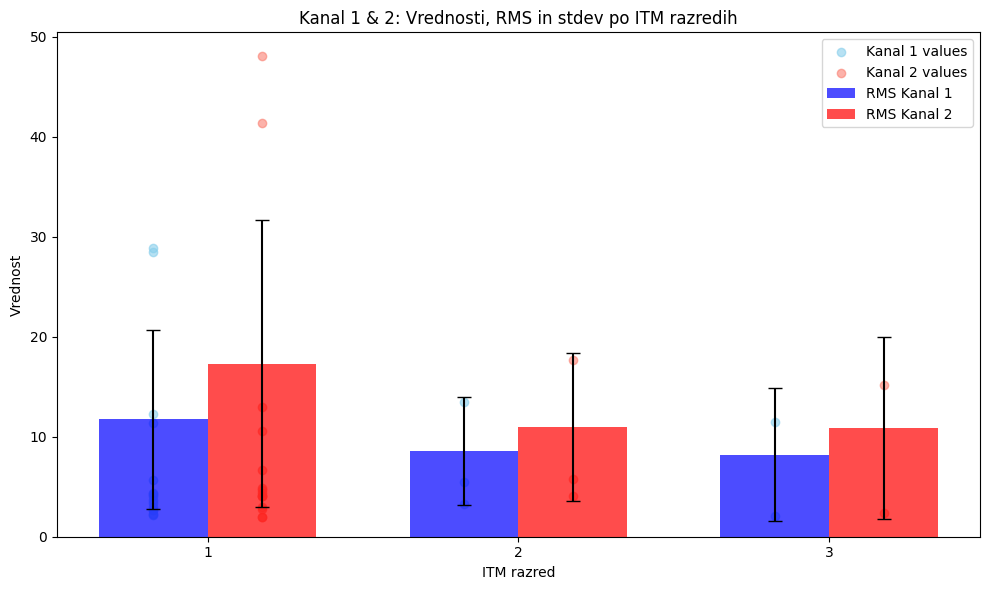

Tel dejav razred (RMS ± stdev):


,Kanal 1,Kanal 2
Tel dejav razred,,
1,16.78 ± 14.37,24.18 ± 21.64
2,6.06 ± 3.60,6.90 ± 4.22
3,10.81 ± 7.83,16.06 ± 12.97


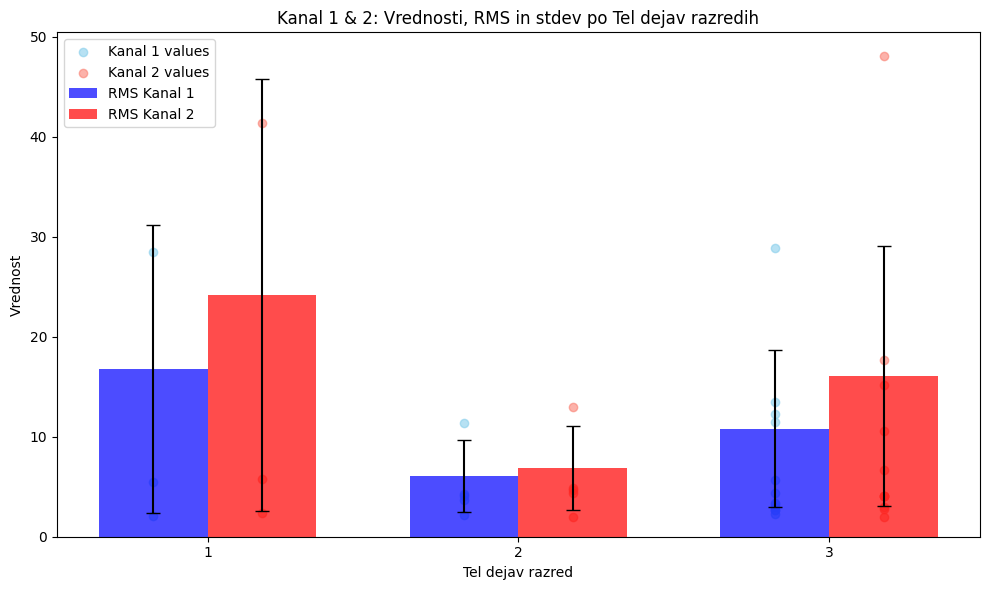


Način: ustpripora
ITM razred (RMS ± stdev):


,Kanal 1,Kanal 2
ITM razred,,
1,4.22 ± 1.95,5.34 ± 3.34
2,5.35 ± 3.11,5.56 ± 3.11
3,2.76 ± 0.28,4.48 ± 1.91


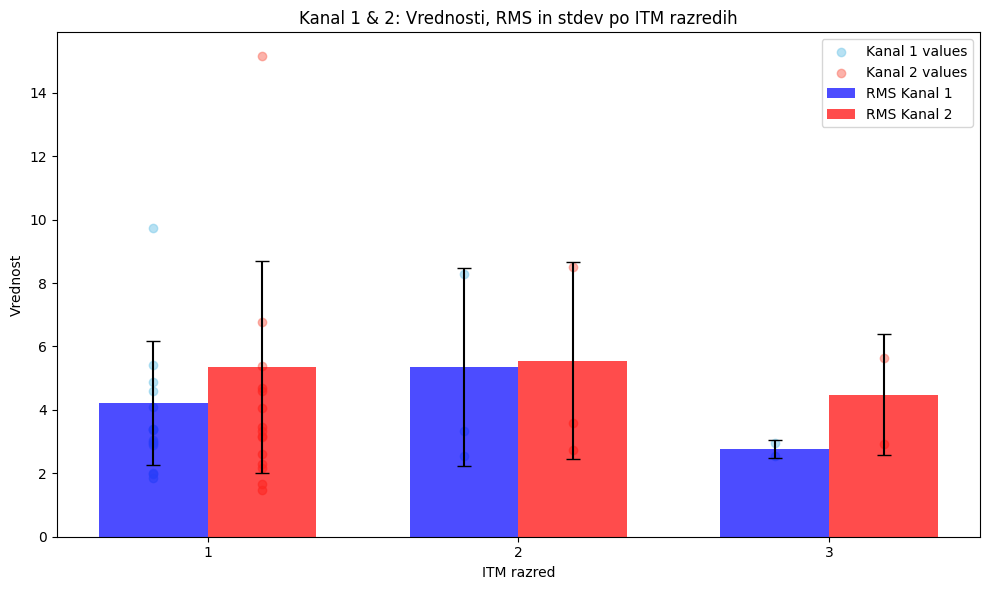

Tel dejav razred (RMS ± stdev):


,Kanal 1,Kanal 2
Tel dejav razred,,
1,5.99 ± 4.15,9.05 ± 7.11
2,3.46 ± 1.27,3.73 ± 2.07
3,4.09 ± 1.68,4.53 ± 1.79


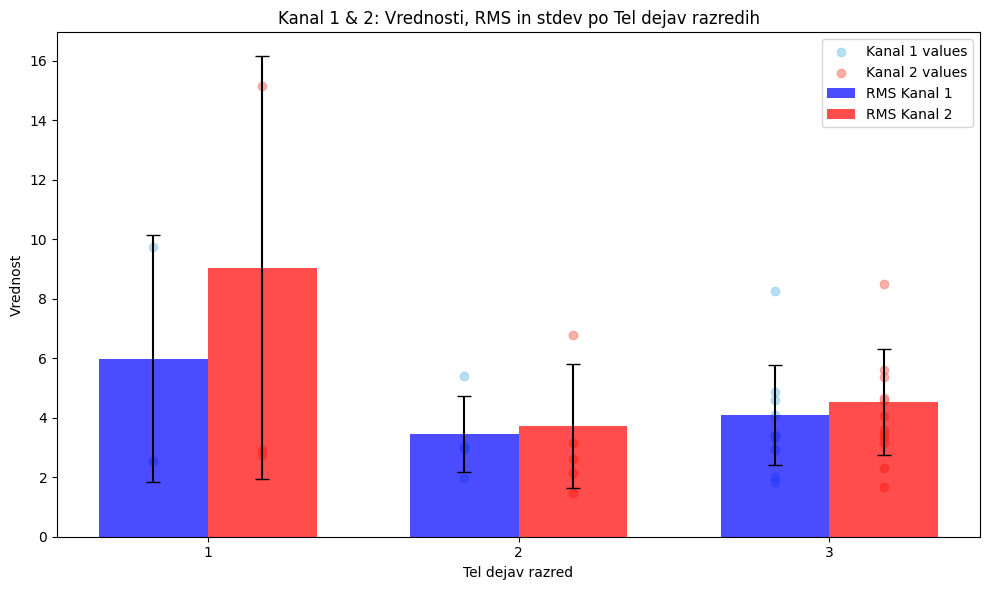


Način: ššš
ITM razred (RMS ± stdev):


,Kanal 1,Kanal 2
ITM razred,,
1,11.51 ± 9.02,11.60 ± 8.90
2,5.06 ± 3.13,5.74 ± 3.49
3,2.43 ± 0.36,2.47 ± 0.13


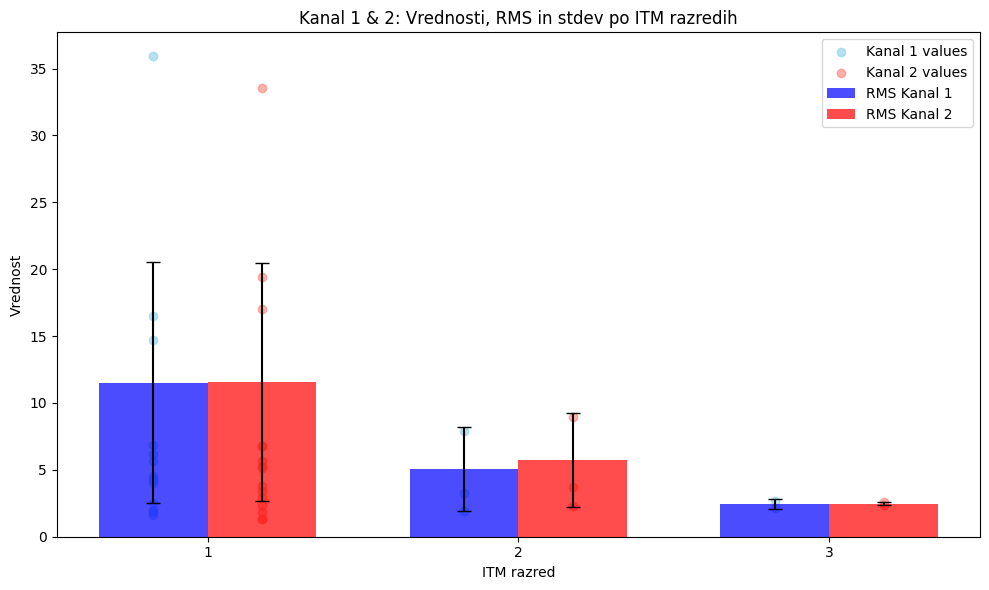

Tel dejav razred (RMS ± stdev):


,Kanal 1,Kanal 2
Tel dejav razred,,
1,9.70 ± 8.19,10.03 ± 8.50
2,4.99 ± 2.38,5.02 ± 2.65
3,11.79 ± 9.71,11.91 ± 9.46


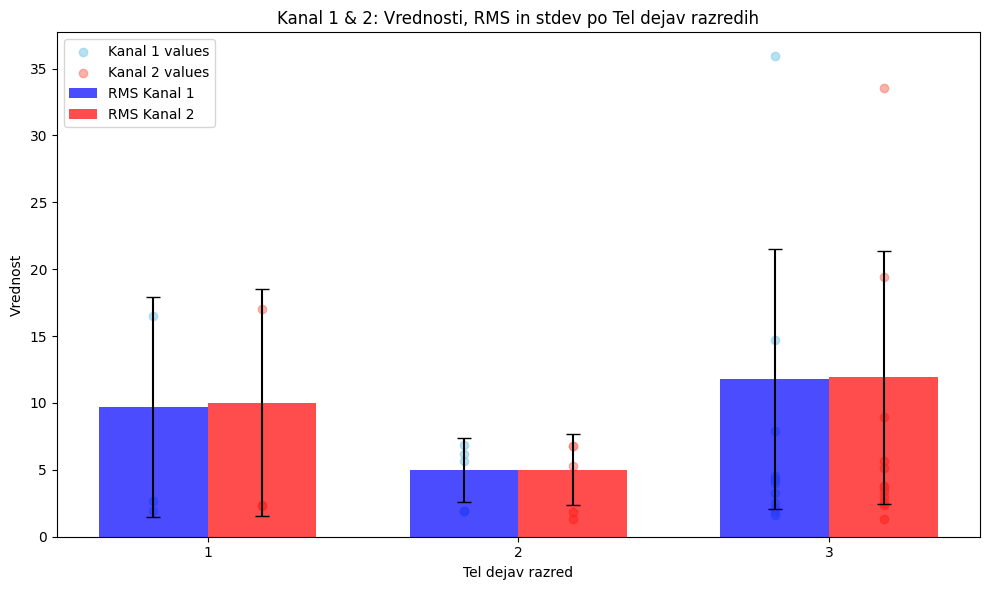


Način: sss
ITM razred (RMS ± stdev):


,Kanal 1,Kanal 2
ITM razred,,
1,9.91 ± 8.29,10.36 ± 8.53
2,4.14 ± 2.54,4.37 ± 2.53
3,2.31 ± 0.48,2.57 ± 0.38


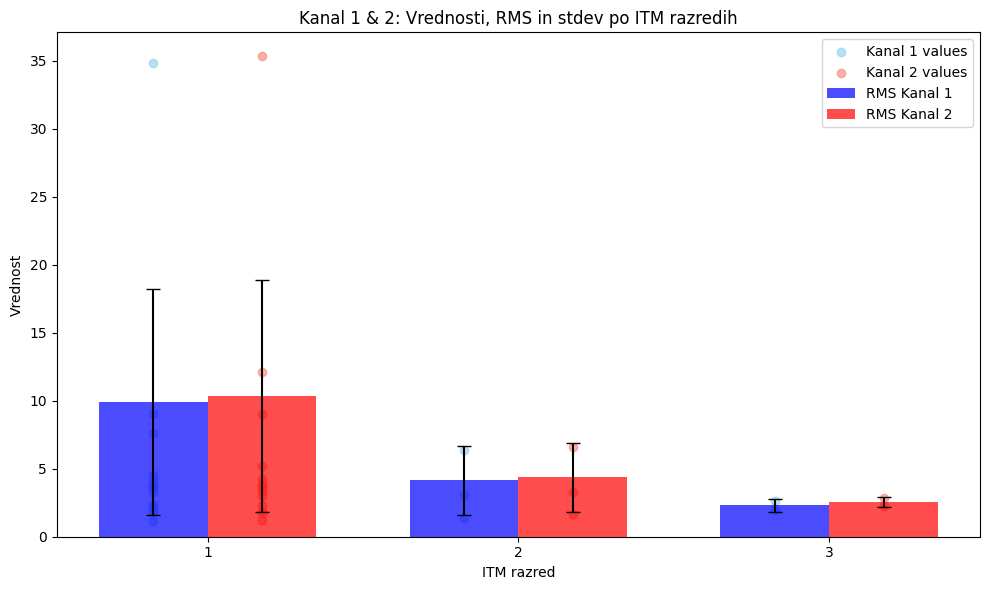

Tel dejav razred (RMS ± stdev):


,Kanal 1,Kanal 2
Tel dejav razred,,
1,2.53 ± 1.22,2.72 ± 1.08
2,4.22 ± 2.45,4.76 ± 3.08
3,10.91 ± 9.15,11.35 ± 9.35


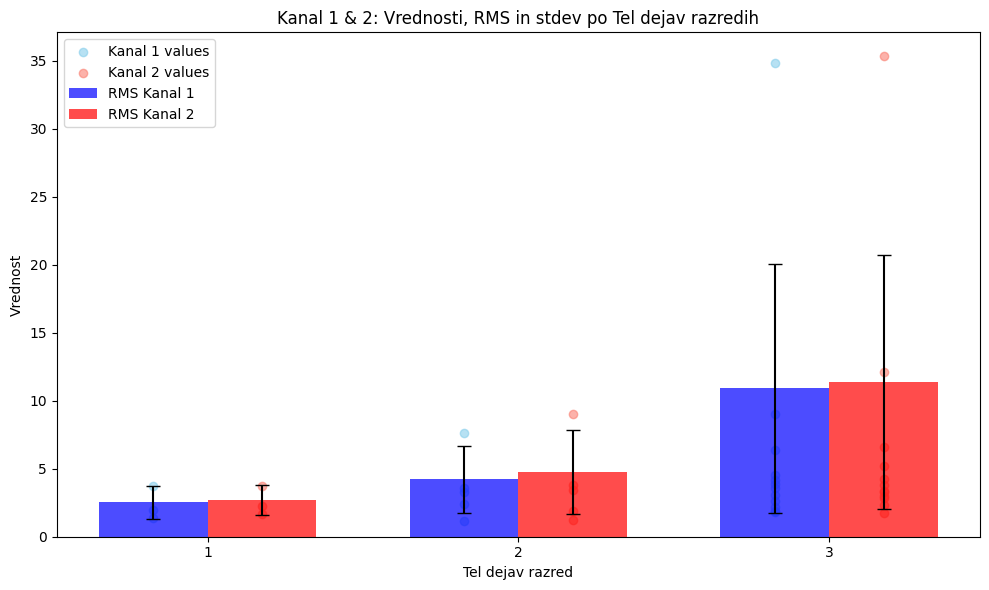


Način: popek
ITM razred (RMS ± stdev):


,Kanal 1,Kanal 2
ITM razred,,
1,22.30 ± 14.53,26.53 ± 18.27
2,20.14 ± 10.68,19.18 ± 10.25
3,27.38 ± 21.39,28.72 ± 24.68


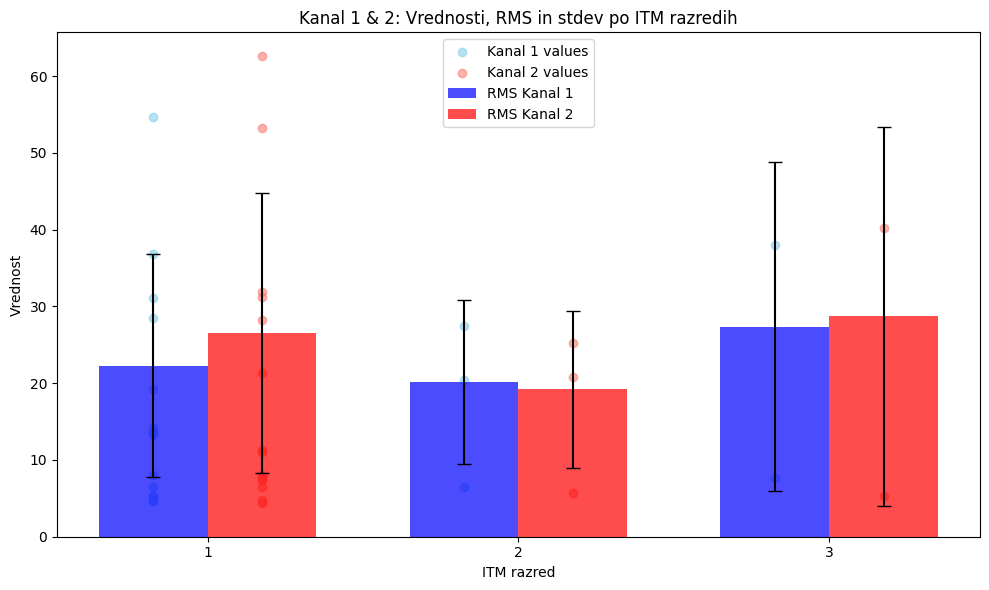

Tel dejav razred (RMS ± stdev):


,Kanal 1,Kanal 2
Tel dejav razred,,
1,24.39 ± 12.60,21.86 ± 13.00
2,27.53 ± 19.03,31.69 ± 22.91
3,19.58 ± 12.56,23.91 ± 16.39


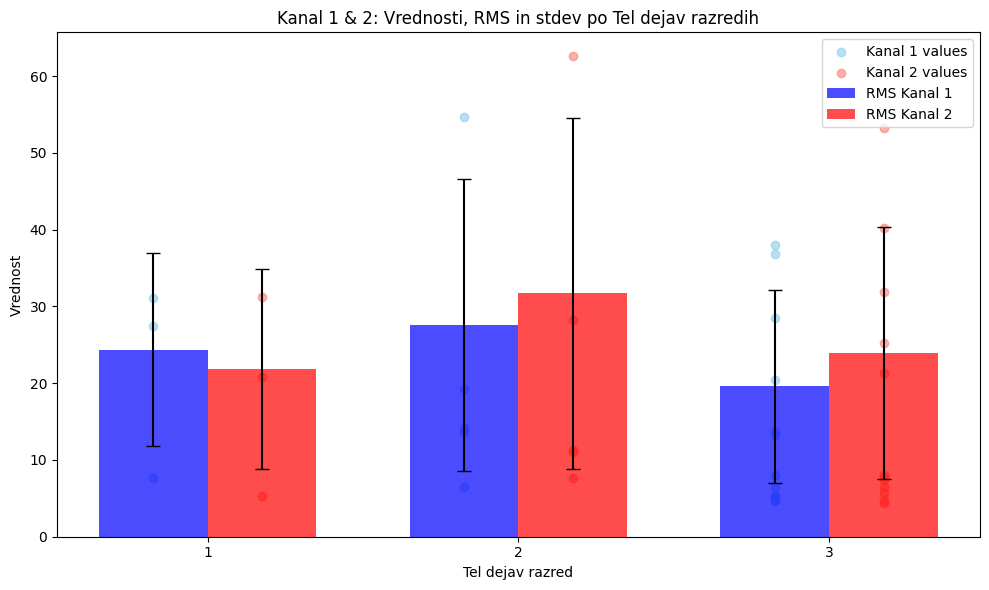


Način: pas
ITM razred (RMS ± stdev):


,Kanal 1,Kanal 2
ITM razred,,
1,45.88 ± 38.02,50.73 ± 41.46
2,19.13 ± 12.57,20.05 ± 13.89
3,37.18 ± 32.67,36.45 ± 31.75


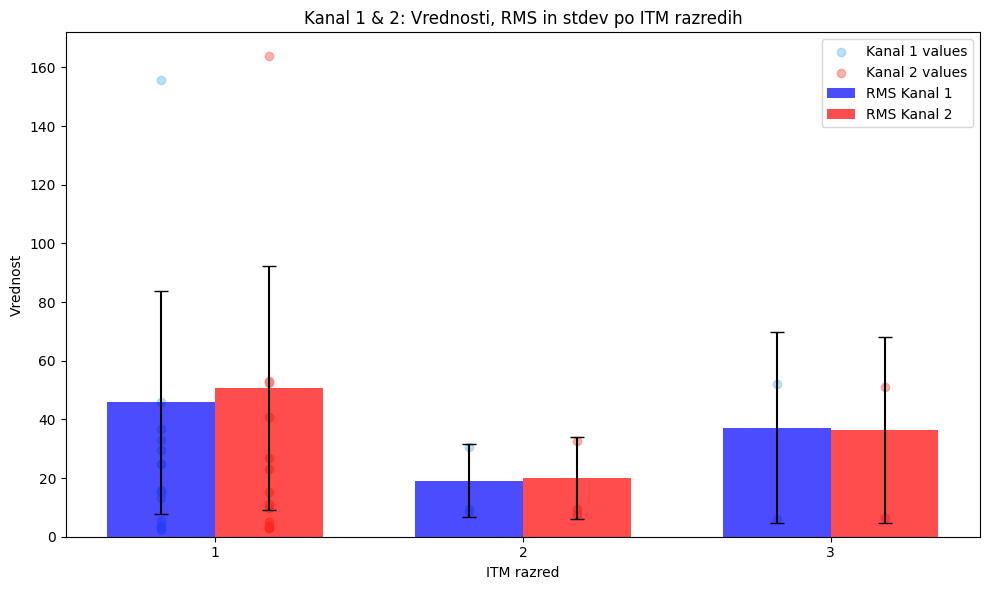

Tel dejav razred (RMS ± stdev):


,Kanal 1,Kanal 2
Tel dejav razred,,
1,91.61 ± 80.19,96.47 ± 84.38
2,28.50 ± 16.69,32.02 ± 20.41
3,22.72 ± 15.60,28.03 ± 20.51


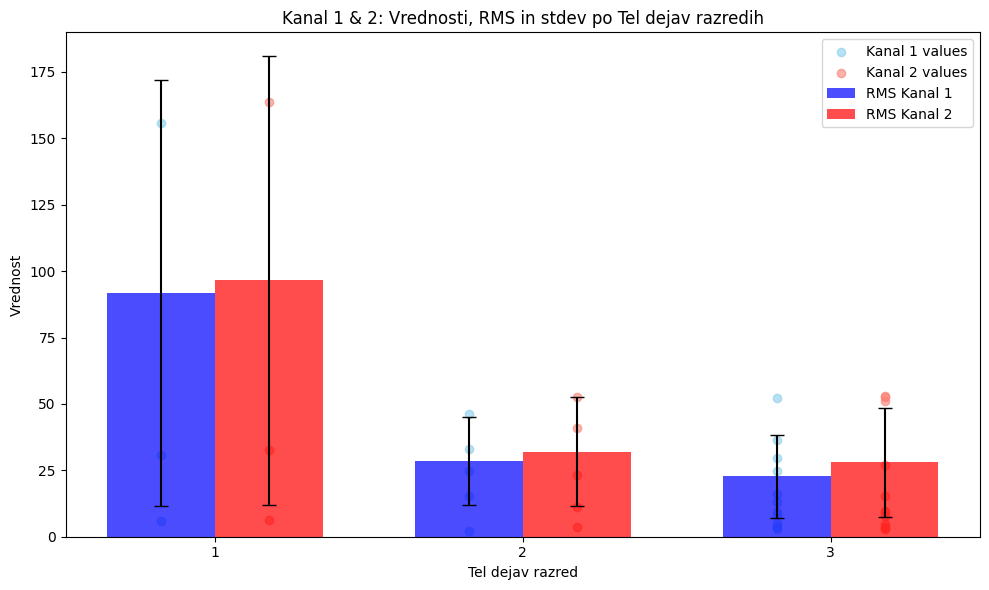

In [49]:
# For each način, group by ITM razred and Tel dejav razred, calculate RMS and stdev, display as "RMS ± stdev"
for nacin in df_all['način'].unique():
    print(f"\nNačin: {nacin}")
    subset = df_all[df_all['način'] == nacin]
    # ITM razred
    rms_itm = subset.groupby('ITM razred')[['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']].apply(calculate_rms)
    std_itm = subset.groupby('ITM razred')[['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']].std()
    table_itm = pd.DataFrame({
        'Kanal 1': [f"{rms_itm.loc[idx, 'Kanal 1 Povprečje mirovanja']:.2f} ± {std_itm.loc[idx, 'Kanal 1 Povprečje mirovanja']:.2f}" for idx in rms_itm.index],
        'Kanal 2': [f"{rms_itm.loc[idx, 'Kanal 2 Povprečje mirovanja']:.2f} ± {std_itm.loc[idx, 'Kanal 2 Povprečje mirovanja']:.2f}" for idx in rms_itm.index]
    }, index=rms_itm.index)
    print("ITM razred (RMS ± stdev):")
    display(table_itm)
    # ITM razred: Plot RMS, stdev, and all values for Kanal 1 and Kanal 2 in one graph
    labels_itm = rms_itm.index
    x_itm = np.arange(len(labels_itm))
    width_itm = 0.35

    fig_itm, ax_itm = plt.subplots(figsize=(10, 6))
    # Scatter all values for Kanal 1 and Kanal 2
    for i, itm in enumerate(labels_itm):
        y1 = subset[subset['ITM razred'] == itm]['Kanal 1 Povprečje mirovanja']
        y2 = subset[subset['ITM razred'] == itm]['Kanal 2 Povprečje mirovanja']
        ax_itm.scatter(np.full_like(y1, x_itm[i] - width_itm/2), y1, color='skyblue', alpha=0.6, label='Kanal 1 values' if i == 0 else "")
        ax_itm.scatter(np.full_like(y2, x_itm[i] + width_itm/2), y2, color='salmon', alpha=0.6, label='Kanal 2 values' if i == 0 else "")
    # Bar RMS with error bars for Kanal 1 and Kanal 2
    ax_itm.bar(x_itm - width_itm/2, rms_itm['Kanal 1 Povprečje mirovanja'], width_itm, yerr=std_itm['Kanal 1 Povprečje mirovanja'], label='RMS Kanal 1', color='blue', alpha=0.7, capsize=5)
    ax_itm.bar(x_itm + width_itm/2, rms_itm['Kanal 2 Povprečje mirovanja'], width_itm, yerr=std_itm['Kanal 2 Povprečje mirovanja'], label='RMS Kanal 2', color='red', alpha=0.7, capsize=5)
    ax_itm.set_ylabel('Vrednost')
    ax_itm.set_xlabel('ITM razred')
    ax_itm.set_title('Kanal 1 & 2: Vrednosti, RMS in stdev po ITM razredih')
    ax_itm.set_xticks(x_itm)
    ax_itm.set_xticklabels(labels_itm)
    ax_itm.legend()
    plt.tight_layout()
    plt.show()

    # Tel dejav razred: Calculate RMS and stdev for Kanal 1 and Kanal 2
    rms_tel = subset.groupby('Tel dejav razred')[['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']].apply(calculate_rms)
    std_tel = subset.groupby('Tel dejav razred')[['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']].std()
    table_tel = pd.DataFrame({
        'Kanal 1': [f"{rms_tel.loc[idx, 'Kanal 1 Povprečje mirovanja']:.2f} ± {std_tel.loc[idx, 'Kanal 1 Povprečje mirovanja']:.2f}" for idx in rms_tel.index],
        'Kanal 2': [f"{rms_tel.loc[idx, 'Kanal 2 Povprečje mirovanja']:.2f} ± {std_tel.loc[idx, 'Kanal 2 Povprečje mirovanja']:.2f}" for idx in rms_tel.index]
    }, index=rms_tel.index)
    print("Tel dejav razred (RMS ± stdev):")
    display(table_tel)

    # Tel dejav razred: Plot RMS, stdev, and all values for Kanal 1 and Kanal 2 in one graph
    labels_tel = rms_tel.index
    x_tel = np.arange(len(labels_tel))
    width_tel = 0.35

    fig_tel, ax_tel = plt.subplots(figsize=(10, 6))
    for i, tel in enumerate(labels_tel):
        y1_tel = subset[subset['Tel dejav razred'] == tel]['Kanal 1 Povprečje mirovanja']
        y2_tel = subset[subset['Tel dejav razred'] == tel]['Kanal 2 Povprečje mirovanja']
        ax_tel.scatter(np.full_like(y1_tel, x_tel[i] - width_tel/2), y1_tel, color='skyblue', alpha=0.6, label='Kanal 1 values' if i == 0 else "")
        ax_tel.scatter(np.full_like(y2_tel, x_tel[i] + width_tel/2), y2_tel, color='salmon', alpha=0.6, label='Kanal 2 values' if i == 0 else "")
    ax_tel.bar(x_tel - width_tel/2, rms_tel['Kanal 1 Povprečje mirovanja'], width_tel, yerr=std_tel['Kanal 1 Povprečje mirovanja'], label='RMS Kanal 1', color='blue', alpha=0.7, capsize=5)
    ax_tel.bar(x_tel + width_tel/2, rms_tel['Kanal 2 Povprečje mirovanja'], width_tel, yerr=std_tel['Kanal 2 Povprečje mirovanja'], label='RMS Kanal 2', color='red', alpha=0.7, capsize=5)
    ax_tel.set_ylabel('Vrednost')
    ax_tel.set_xlabel('Tel dejav razred')
    ax_tel.set_title('Kanal 1 & 2: Vrednosti, RMS in stdev po Tel dejav razredih')
    ax_tel.set_xticks(x_tel)
    ax_tel.set_xticklabels(labels_tel)
    ax_tel.legend()
    plt.tight_layout()
    plt.show()


In [50]:
# Check normality for Kanal 1 & 2 Povprečje mirovanja by ITM razred and Tel dejav razred
normality_by_itm_tel = []

for kanal in ['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']:
    # ITM razred
    for itm in df_all['ITM razred'].unique():
        group = df_all[df_all['ITM razred'] == itm][kanal].dropna()
        if len(group) > 2:
            stat, p = shapiro(group)
            interpretation = "Normal" if p >= 0.05 else "Not normal"
            normality_by_itm_tel.append({
                'Channel': kanal,
                'Group': f'ITM razred {itm}',
                'Statistic': stat,
                'p-value': p,
                'Interpretation': interpretation
            })
    # Tel dejav razred
    for tel in df_all['Tel dejav razred'].unique():
        group = df_all[df_all['Tel dejav razred'] == tel][kanal].dropna()
        if len(group) > 2:
            stat, p = shapiro(group)
            interpretation = "Normal" if p >= 0.05 else "Not normal"
            normality_by_itm_tel.append({
                'Channel': kanal,
                'Group': f'Tel dejav razred {tel}',
                'Statistic': stat,
                'p-value': p,
                'Interpretation': interpretation
            })

normality_by_itm_tel_df = pd.DataFrame(normality_by_itm_tel)
display(normality_by_itm_tel_df)

,Channel,Group,Statistic,p-value,Interpretation
0,Kanal 1 Povprečje mirovanja,ITM razred 1,0.491438,4.147211e-16,Not normal
1,Kanal 1 Povprečje mirovanja,ITM razred 2,0.776543,7.215852e-04,Not normal
2,Kanal 1 Povprečje mirovanja,ITM razred 3,0.614889,1.431683e-04,Not normal
3,Kanal 1 Povprečje mirovanja,Tel dejav razred 2,0.675482,6.994291e-07,Not normal
4,Kanal 1 Povprečje mirovanja,Tel dejav razred 1,0.493622,7.059637e-07,Not normal
5,Kanal 1 Povprečje mirovanja,Tel dejav razred 3,0.686245,4.051688e-11,Not normal
6,Kanal 2 Povprečje mirovanja,ITM razred 1,0.530870,1.748201e-15,Not normal
7,Kanal 2 Povprečje mirovanja,ITM razred 2,0.786532,9.862898e-04,Not normal
8,Kanal 2 Povprečje mirovanja,ITM razred 3,0.626002,1.782848e-04,Not normal
9,Kanal 2 Povprečje mirovanja,Tel dejav razred 2,0.647606,2.933147e-07,Not normal


Nič ni normalno, zato uporabimo neparametrične teste, najprej kruskal za 3 skupine nato mannwhitneyu za 2 skupini.

In [54]:
results = []

for nacin in df_all['način'].unique():
    subset = df_all[df_all['način'] == nacin]
    
    # ITM razred
    for kanal in ['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']:
        groups = [subset[subset['ITM razred'] == itm][kanal].dropna() for itm in sorted(subset['ITM razred'].unique())]
        if all(len(g) > 0 for g in groups) and len(groups) > 1:
            stat, p = kruskal(*groups)
            results.append({
                'način': nacin,
                'Group': 'ITM razred',
                'Channel': kanal,
                'Statistic': stat,
                'p-value': p
            })
        else:
            results.append({
                'način': nacin,
                'Group': 'ITM razred',
                'Channel': kanal,
                'Statistic': None,
                'p-value': None
            })
    # Tel dejav razred
    for kanal in ['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']:
        groups = [subset[subset['Tel dejav razred'] == tel][kanal].dropna() for tel in sorted(subset['Tel dejav razred'].unique())]
        if all(len(g) > 0 for g in groups) and len(groups) > 1:
            stat, p = kruskal(*groups)
            results.append({
                'način': nacin,
                'Group': 'Tel dejav razred',
                'Channel': kanal,
                'Statistic': stat,
                'p-value': p
            })
        else:
            results.append({
                'način': nacin,
                'Group': 'Tel dejav razred',
                'Channel': kanal,
                'Statistic': None,
                'p-value': None
            })

results_df = pd.DataFrame(results)
display(results_df)


,način,Group,Channel,Statistic,p-value
0,nosnos,ITM razred,Kanal 1 Povprečje mirovanja,0.642857,0.725112
1,nosnos,ITM razred,Kanal 2 Povprečje mirovanja,0.340952,0.843263
2,nosnos,Tel dejav razred,Kanal 1 Povprečje mirovanja,0.232381,0.890306
3,nosnos,Tel dejav razred,Kanal 2 Povprečje mirovanja,0.154762,0.925537
4,ustpripora,ITM razred,Kanal 1 Povprečje mirovanja,1.297143,0.522792
5,ustpripora,ITM razred,Kanal 2 Povprečje mirovanja,0.554286,0.757946
6,ustpripora,Tel dejav razred,Kanal 1 Povprečje mirovanja,0.384762,0.824993
7,ustpripora,Tel dejav razred,Kanal 2 Povprečje mirovanja,2.112857,0.347695
8,ššš,ITM razred,Kanal 1 Povprečje mirovanja,0.931429,0.627687
9,ššš,ITM razred,Kanal 2 Povprečje mirovanja,1.054286,0.590289


Vse je isto.

Poskusimo za dve mann whitney u test za dve grupi

In [55]:
# Create a copy of df_all and merge values in both columns
df_all_merged = df_all.copy()
df_all_merged['Tel dejav razred'] = df_all_merged['Tel dejav razred'].replace(1, 2)
df_all_merged['ITM razred'] = df_all_merged['ITM razred'].replace(3, 2)
df_all_merged['Tel dejav razred'] = df_all_merged['Tel dejav razred'].replace({2: 1, 3: 2})

# Display the new table with merged columns
display(df_all_merged.head())

,način,ID,ITM razred,Tel dejav razred,Kanal 1 Povprečje delovanja,Kanal 1 Odklon od povprečja delovanja,Column1,Kanal 1 Vrh,Kanal 2 Povprečje delovanja,Kanal 2 Odklon od povprečja delovanja,Column2,Kanal 2 Vrh,Kanal 1 Povprečje mirovanja,Kanal 1 Odklon od povprečja mirovanja,Column3,Kanal 1 Minimum,Kanal 2 Povprečje mirovanja,Kanal 2 Odklon od povprečja mirovanja,Column4,Kanal 2 Minimum
0,nosnos,1354,1,1,3.536849,0.621890,0.175832,10.9,4.366164,0.874796,0.200358,10.90,3.695455,0.805859,0.218068,1.27,4.669596,0.945205,0.202417,1.53
1,ustpripora,1354,1,1,2.243514,0.582542,0.259656,5.4,1.592973,0.544719,0.341951,5.41,1.986578,0.458973,0.231037,0.74,1.460199,0.441143,0.302112,0.56
2,ššš,1354,1,1,2.157181,0.503344,0.233334,6.3,1.670940,0.484776,0.290122,7.40,1.954916,0.404280,0.206802,0.84,1.862155,0.565431,0.303643,0.57
3,sss,1354,1,1,2.524362,0.496311,0.196608,5.3,2.017450,0.572784,0.283915,5.80,2.384983,0.476827,0.199929,1.11,1.905797,0.516088,0.270799,0.87
4,popek,1354,1,1,13.964437,2.621669,0.187739,55.0,19.255364,4.528746,0.235194,96.00,19.278389,6.835292,0.354557,5.80,28.180705,11.823276,0.419552,5.40


In [57]:
from scipy.stats import mannwhitneyu
import pandas as pd

results = []

nacini = df_all_merged['način'].unique()
for nacin in nacini:
    subset = df_all_merged[df_all_merged['način'] == nacin]
    for kanal in ['Kanal 1 Povprečje mirovanja', 'Kanal 2 Povprečje mirovanja']:
        # ITM razred
        itm_groups = sorted(subset['ITM razred'].unique())
        if len(itm_groups) == 2:
            group1 = subset[subset['ITM razred'] == itm_groups[0]][kanal].dropna()
            group2 = subset[subset['ITM razred'] == itm_groups[1]][kanal].dropna()
            if len(group1) > 0 and len(group2) > 0:
                stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
                results.append({
                    'način': nacin,
                    'Channel': kanal,
                    'Group': 'ITM razred',
                    'Group1': itm_groups[0],
                    'Group2': itm_groups[1],
                    'U': stat,
                    'p-value': p
                })
        # Tel dejav razred
        tel_groups = sorted(subset['Tel dejav razred'].unique())
        if len(tel_groups) == 2:
            group1 = subset[subset['Tel dejav razred'] == tel_groups[0]][kanal].dropna()
            group2 = subset[subset['Tel dejav razred'] == tel_groups[1]][kanal].dropna()
            if len(group1) > 0 and len(group2) > 0:
                stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
                results.append({
                    'način': nacin,
                    'Channel': kanal,
                    'Group': 'Tel dejav razred',
                    'Group1': tel_groups[0],
                    'Group2': tel_groups[1],
                    'U': stat,
                    'p-value': p
                })

results_df = pd.DataFrame(results)
display(results_df)

,način,Channel,Group,Group1,Group2,U,p-value
0,nosnos,Kanal 1 Povprečje mirovanja,ITM razred,1,2,35.0,0.865970
1,nosnos,Kanal 1 Povprečje mirovanja,Tel dejav razred,1,2,44.0,0.792077
2,nosnos,Kanal 2 Povprečje mirovanja,ITM razred,1,2,33.0,0.735423
3,nosnos,Kanal 2 Povprečje mirovanja,Tel dejav razred,1,2,49.0,0.969929
4,ustpripora,Kanal 1 Povprečje mirovanja,ITM razred,1,2,44.0,0.611584
5,ustpripora,Kanal 1 Povprečje mirovanja,Tel dejav razred,1,2,40.0,0.571358
6,ustpripora,Kanal 2 Povprečje mirovanja,ITM razred,1,2,29.0,0.497291
7,ustpripora,Kanal 2 Povprečje mirovanja,Tel dejav razred,1,2,33.0,0.270271
8,ššš,Kanal 1 Povprečje mirovanja,ITM razred,1,2,47.0,0.444530
9,ššš,Kanal 1 Povprečje mirovanja,Tel dejav razred,1,2,48.0,1.000000


Interpretation:

A small p-value (typically < 0.05) means at least one group is different.
A large p-value means no significant difference between group medians. (čudni rezultati!)

Poiskus 
# Cohen's d between two groups for Kanal 1 Povprečje mirovanja in 'pas' način, ITM razred 1 vs 2


In [58]:
def cohen_d(x, y):
    """Calculate Cohen's d for two independent samples."""
    nx = len(x)
    ny = len(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

# Example usage:
# Cohen's d between two groups for Kanal 1 Povprečje mirovanja in 'pas' način, ITM razred 1 vs 2
group1 = subset[subset['ITM razred'] == 1]['Kanal 1 Povprečje mirovanja'].dropna()
group2 = subset[subset['ITM razred'] == 2]['Kanal 1 Povprečje mirovanja'].dropna()
d = cohen_d(group1, group2)
print(f"Cohen's d: {d:.3f}")

Cohen's d: 0.177
